In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob
import shutil

In [5]:
torch.backends.cudnn.benchmark=True

## Data

In [6]:
VAL_PATH = Path('../data/val')

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

In [7]:
(ALL_PATH/TRAIN_DN).mkdir(exist_ok=True)
(ALL_PATH/MASKS_DN).mkdir(exist_ok=True)

In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

### Resize images

In [16]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz = 300
ratio = 4/3

In [17]:
(VAL_PATH/f'{MASKS_DN}-{sz}').mkdir(exist_ok=True)

In [18]:
def resize_mask(fn):
    Image.open(fn).resize((int(sz*ratio),sz)).save((fn.parent.parent)/f'{MASKS_DN}-{sz}'/fn.name)

files = list((VAL_PATH/MASKS_DN).iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [19]:
(VAL_PATH/f'{TRAIN_DN}-{sz}').mkdir(exist_ok=True)

In [20]:
def resize_img(fn):
    Image.open(fn).resize((int(sz*ratio),sz)).save((fn.parent.parent)/f'{TRAIN_DN}-{sz}'/fn.name)

files = list((VAL_PATH/TRAIN_DN).iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [21]:
len(glob(str(VAL_PATH/(TRAIN_DN+'-150')/'*.png'))), len(glob(str(VAL_PATH/(MASKS_DN+'-300')/'*.png')))

(30, 30)

### View Data

In [24]:
pths = glob(str(ALL_PATH/(TRAIN_DN)/'*.png'))

In [25]:
pth = pths[0]

PosixPath('../data/Train/AnswersRGB-150/1.png')

In [26]:
plt.imread(str(pth)).shape

(150, 200, 3)

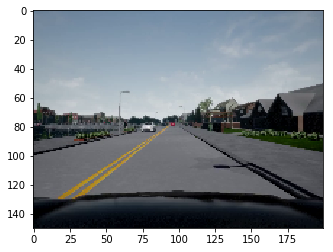

In [27]:
plt.imshow(plt.imread(str(pth)))

### Create dataloader

In [355]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
#             return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            return np.dstack((im[:,:,2]==ROADS, im[:,:,2]==VEHICLES, (im[:,:,2]!=VEHICLES) & (im[:,:,2]!=ROADS))).astype(np.float32)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [356]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 2
#     def get(self, tfm, x, y):
#         x,y = super().get(tfm, x, y)
#         print(np.mean(y[0,:,:]))
#         print(np.mean(y[2,:,:]))
#         y = np.stack((y[0,:,:]==ROADS, y[0,:,:]==VEHICLES, (y[0,:,:]!=VEHICLES) & (y[0,:,:]!=ROADS)))
#         return x,y.astype(np.int)

In [239]:
x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))

In [354]:
open_image(x_names[0]).shape

(600, 800, 3)

In [174]:
VEHICLES=10
ROADS=7

In [27]:
# x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
# y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [28]:
len(x_names)

1000

In [257]:
ya = cv2.imread(y_names[0])

In [258]:
ya.shape

(600, 800, 3)

In [270]:
ry = np.rollaxis(ya,2,0)

In [273]:
ry.shape

(3, 600, 800)

In [306]:
(ya[0,:,:]==ROADS).shape

(800, 3)

In [313]:
y = y[0]

In [314]:
y.shape

torch.Size([3, 256, 256])

In [320]:
ya.astype(np.int)

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0, 10],
        [ 0,  0, 10],
        [ 0,  0, 10],
        ...,
        [ 0,  0, 10],
        [ 0,  0, 10],
        [ 0,  0, 10]],

       [[ 0,  0, 10],
        [ 0,  0, 10],
        [ 0,  0, 10],
        ...,
        [ 0,  0, 10],
        [ 0,  0, 10],
        [ 0,  0, 10]],

       [[ 0,  0, 10],
        [ 0,  0, 10],
        [ 0,  0, 10],
        ...,
        [ 0,  0, 10],
        [ 0,  0, 10],
        [ 0,  0, 10]]])

In [315]:
np.stack((y[0,:,:]==ROADS, y[0,:,:]==VEHICLES, (y[0,:,:]!=VEHICLES) & (y[0,:,:]!=ROADS))).shape

(3, 256, 256)

In [155]:
a = np.array((ya[:,:,2]==ROADS, ya[:,:,2]==VEHICLES))

In [170]:
np.dstack((ya[:,:,2]==ROADS, ya[:,:,2]==VEHICLES)).shape

(600, 800, 2)

In [163]:
np.rollaxis(a, 0, 3).shape

(600, 800, 2)

In [151]:
(ya[:,:,2]==ROADS).shape

(600, 800)

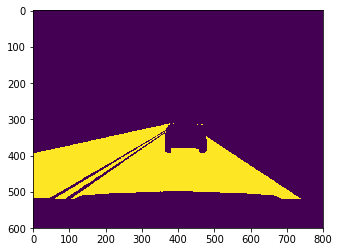

In [113]:
plt.imshow(ya[:,:,2]==ROADS)

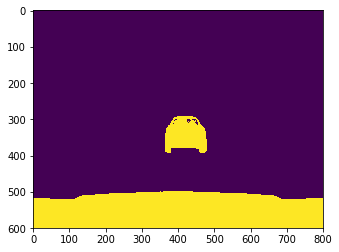

In [114]:
plt.imshow(ya[:,:,2]==VEHICLES)

In [93]:
np.mean(ya)

1.6352770833333334

In [108]:
np.mean(ya[:,:,2])

4.90583125

In [115]:
ya[...,0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
ya[:,:,2] =

In [66]:
np.mean(ya[2])

0.0

In [284]:
bs=2

In [357]:
val_idxs = list(range(100))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [358]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [359]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
# tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
denorm = md.trn_ds.denorm

In [360]:
x,y = next(iter(md.trn_dl))

In [361]:
x.shape,y.shape

(torch.Size([2, 3, 256, 256]), torch.Size([2, 3, 256, 256]))

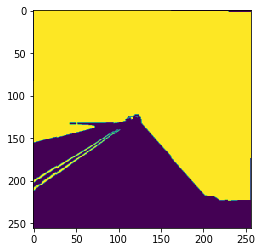

In [364]:
plt.imshow(y[0][2])

In [144]:
a = y[0]

In [143]:
plt.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'

## Simple upsample

In [210]:
f = resnet34
cut,lr_cut = model_meta[f]

In [211]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [212]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [213]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [214]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [215]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [216]:
m_base = get_base()

In [217]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [218]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [219]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('BatchNorm2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                        

In [220]:
learn.freeze_to(1)

In [221]:
learn.lr_find()
learn.sched.plot()

  0%|          | 0/15 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([64, 3, 256, 256])) must be the same as input size (torch.Size([64, 256, 256]))

In [82]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [83]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.389226   177.188503 0.191106   0.037023  
    1      0.264491   0.353331   0.342328   0.007222       
    2      0.20553    0.113036   0.344406   0.0            
    3      0.167829   0.105428   0.344406   0.0            



[array([0.10543]), 0.3444055211544037, 0.0]

In [36]:
learn.save('tmp')

In [27]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [38]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.174897   0.061603   0.976321   0.94382   
    1      0.122911   0.053625   0.982206   0.957624       
    2      0.106837   0.046653   0.985577   0.965792       
    3      0.099075   0.042291   0.986519   0.968925        



[0.042291240323157536, 0.986519161670927, 0.9689251193924556]

In [39]:
learn.save('128')

In [84]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

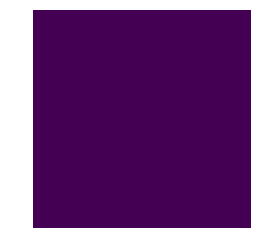

In [87]:
show_img(py[0]>0);

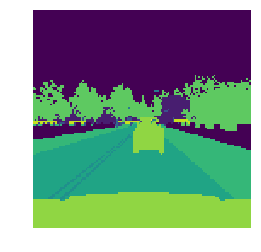

In [88]:
show_img(y[0]);

## U-net (ish)

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [20]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [33]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 1, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [34]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [30]:
m_base = get_base()

In [31]:
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [32]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [34]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [35]:
learn.freeze_to(1)

 91%|█████████ | 58/64 [00:13<00:01,  4.39it/s, loss=1.57] 

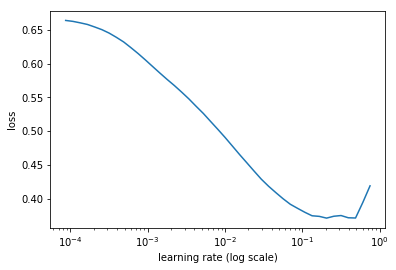

In [90]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [37]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.142851   0.038569   0.988547   0.971717  
    1      0.101173   0.03713    0.988605   0.975992       
    2      0.08908    0.039838   0.986759   0.972326        
    3      0.081489   0.029241   0.992063   0.979739        
    4      0.079016   0.028968   0.991646   0.97719         
    5      0.076655   0.023804   0.992451   0.982042        
    6      0.07636    0.024756   0.992738   0.983401        
    7      0.07495    0.028137   0.993225   0.983095        



[0.028136500290461948, 0.993224613250248, 0.9830952419175042]

In [38]:
learn.save('128urn-tmp')

In [56]:
learn.load('128urn-tmp')

In [39]:
learn.unfreeze()
learn.bn_freeze(True)

In [40]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.074118   0.020005   0.993274   0.983666  
    1      0.073695   0.021194   0.993121   0.984339        
    2      0.073121   0.024444   0.993327   0.984351        
    3      0.071765   0.021549   0.993588   0.984733        
    4      0.072239   0.019336   0.993528   0.985078        
    5      0.071364   0.01934    0.993351   0.985128        
    6      0.071399   0.018902   0.993654   0.985341        
    7      0.071632   0.020567   0.993527   0.985378        
    8      0.070797   0.019375   0.993866   0.985641        
    9      0.070172   0.019292   0.993802   0.985716        



[0.019291689264632407, 0.9938022683537195, 0.9857159994897389]

In [41]:
learn.save('128urn-0')

In [26]:
learn.load('128urn-0')

In [42]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

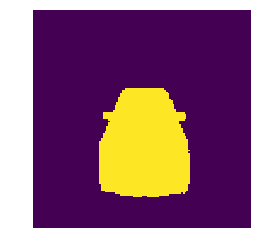

In [43]:
show_img(py[0]>0);

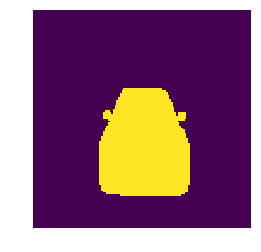

In [44]:
show_img(y[0]);

In [45]:
m.close()

## 512x512

In [23]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'

In [24]:
sz=512
bs=8

In [25]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [26]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [27]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [28]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [35]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [36]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [37]:
learn.freeze_to(1)

In [38]:
learn.load('128urn-0')

In [39]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.072306   0.024262   0.995649   0.990836  
    1      0.070101   0.018257   0.996652   0.992687          
    2      0.068719   0.013143   0.996877   0.992726          
    3      0.067462   0.01673    0.997156   0.993161          
    4      0.069176   0.010519   0.997248   0.993573          



[0.010519474116523587, 0.9972476694318984, 0.9935726703159393]

In [40]:
learn.save('512urn-tmp')

In [41]:
learn.unfreeze()
learn.bn_freeze(True)

In [38]:
learn.load('512urn-tmp')

In [42]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.066793   0.009628   0.997183   0.993656  
    1      0.064545   0.010879   0.997386   0.993893          
    2      0.06125    0.010519   0.997421   0.994018          
    3      0.06288    0.01147    0.997403   0.99407           
    4      0.064336   0.008862   0.997411   0.994132          
    5      0.063767   0.009989   0.997463   0.994194          
    6      0.063922   0.009927   0.997504   0.994277          
    7      0.06392    0.008977   0.997514   0.994242          



[0.00897712022110465, 0.9975136726621597, 0.9942418502436744]

In [73]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.06605    0.013602   0.997      0.993014  
    1      0.066885   0.011252   0.997248   0.993563          
    2      0.065796   0.009802   0.997223   0.993817          
    3      0.065089   0.009668   0.997296   0.993744          
    4      0.064552   0.011683   0.997269   0.993835          
    5      0.065089   0.010553   0.997415   0.993827          
    6      0.064303   0.009472   0.997431   0.994046          
    7      0.062506   0.009623   0.997441   0.994118          



[0.009623114736602894, 0.9974409020136273, 0.9941179137381296]

In [74]:
learn.save('512urn')

In [26]:
learn.load('512urn')

In [75]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

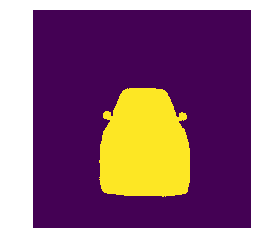

In [76]:
show_img(py[0]>0);

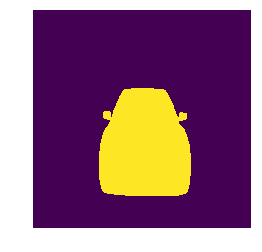

In [77]:
show_img(y[0]);

In [78]:
m.close()

## 1024x1024

In [26]:
sz=1024
bs=4

In [27]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [28]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [29]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [30]:
learn.load('512urn')

In [31]:
learn.freeze_to(1)

In [32]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.007656   0.008155   0.997247   0.99353   
    1      0.004706   0.00509    0.998039   0.995437             



[0.005090427414942828, 0.9980387706605215, 0.995437301104031]

In [33]:
learn.save('1024urn-tmp')

In [30]:
learn.load('1024urn-tmp')

In [31]:
learn.unfreeze()
learn.bn_freeze(True)

In [32]:
lrs = np.array([lr/200,lr/30,lr])

In [33]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.005688   0.006135   0.997616   0.994616  
    1      0.004412   0.005223   0.997983   0.995349             
    2      0.004186   0.004975   0.99806    0.99554              
    3      0.004016   0.004899   0.99812    0.995627             



[0.004898778487196458, 0.9981196409180051, 0.9956271404784823]

In [33]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.004169   0.004962   0.998049   0.995517  
    1      0.004022   0.004595   0.99823    0.995818             
    2      0.003772   0.004497   0.998215   0.995916             
    3      0.003618   0.004435   0.998291   0.995991             



[0.004434524739663753, 0.9982911745707194, 0.9959913929776539]

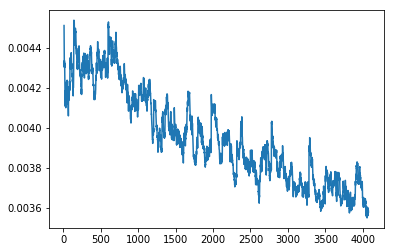

In [34]:
learn.sched.plot_loss()

In [35]:
learn.save('1024urn')

In [26]:
learn.load('1024urn')

In [36]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

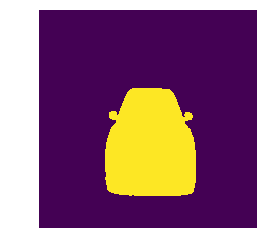

In [37]:
show_img(py[0]>0);

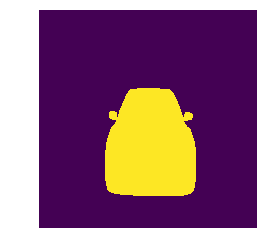

In [38]:
show_img(y[0]);